Attempt at morpheme-based embedding learning. Need to try FastText model

I used this [code](https://github.com/nzw0301/keras-examples/blob/master/Skip-gram-with-NS.ipynb) as a basis for learning skipgram embeddings in Keras



In [3]:
import os
import random
import sys
import subprocess
from operator import itemgetter

import re
import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

import morfessor

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.mlab as mlab
%matplotlib inline

sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

### Read in poetry corpus

In [34]:
# read in all the poems 
path = '/Users/ChadMorgan/Documents/old_english/OldEnglishPoetryCorpus/scraped_corpus'
contents = os.listdir(path)

In [652]:
corpus_lines = []
token_dict = {}
token_set = set()

for poem in contents:
    # read full poem and split into sentences / independent clauses
    poem_text_raw = open(path+'/'+poem).read()
    poem_lines = re.split("\.|\!|\?|\;",poem_text_raw)
    for line in poem_lines:
        # remove punctuation and extra whitespace
        line = re.sub("\.|\:|\!|\,|\n|\;",'',line)
        line = re.sub("$ | ^",'',line)
        line_tokens = line.split(' ')
        line_tokens_clean = []
        for l in line_tokens:
            if l != '':
                # use of q is only in latin loanwords. 
                # xx should only occur in roman numerals
                if re.search('q',l) or re.search('xx',l) or re.search('text[0-9]+',l):
                    continue
                # valid words must contain a vowel
                elif re.search("['y','i','u','e','o','æ','a']",l):
                    line_tokens_clean += [l]
                    if l not in token_set:
                        token_dict[l] = 1
                        token_set.add(l)
                    else:
                        token_dict[l] += 1
        if len(line_tokens_clean)>0:
            corpus_lines += [" ".join(line_tokens_clean)]

            
flat_tokens = [item for sublist in corpus_lines for item in sublist]    

In [657]:
token_count = pd.DataFrame.from_dict(token_dict,orient='index').reset_index()
token_count.columns = ['token','freq']
token_count = token_count.sort_values('freq',ascending=False)\
    .reset_index(drop=True)
print("Top words by frequency:")
print(token_count.head(10))

print("Unique words:",len(token_count))
print("Words with one occurence:",len(token_count[token_count['freq']==1])
      ,"(",round(len(token_count[token_count['freq']==1])/len(token_count),3)*100,"%)")

token_count = token_count[['freq','token']].reset_index()
token_count['constant'] = 0

Top words by frequency:
  token  freq
0    on  4380
1   and  3177
2   þæt  2913
3    þa  2168
4    ic  2091
5   ond  2055
6    he  1943
7    þe  1930
8    ne  1867
9    to  1813
Unique words: 26977
Words with one occurence: 16032 ( 59.4 %)


In [784]:
token_count[token_count['token']=='gif']

,index,freq,token,constant,token_split,token_split_ct
55,55,321,gif,0,[gif],1


### Fit morphology model

In [748]:
token_list = token_count[['freq','constant','token']].values.tolist()
print(token_list[0:60])

[[4380, 0, 'on'], [3177, 0, 'and'], [2913, 0, 'þæt'], [2168, 0, 'þa'], [2091, 0, 'ic'], [2055, 0, 'ond'], [1943, 0, 'he'], [1930, 0, 'þe'], [1867, 0, 'ne'], [1813, 0, 'to'], [1642, 0, 'him'], [1380, 0, 'se'], [1280, 0, 'swa'], [1205, 0, 'his'], [1177, 0, 'mid'], [1171, 0, 'me'], [1154, 0, 'wæs'], [1053, 0, 'þu'], [1022, 0, 'in'], [893, 0, 'þær'], [800, 0, 'þonne'], [793, 0, 'þam'], [779, 0, 'is'], [700, 0, 'nu'], [695, 0, 'þæs'], [688, 0, 'of'], [661, 0, 'ofer'], [642, 0, 'hi'], [632, 0, 'god'], [623, 0, 'ða'], [616, 0, 'þurh'], [539, 0, 'drihten'], [537, 0, 'ðe'], [521, 0, 'ealle'], [503, 0, 'ær'], [476, 0, 'ac'], [442, 0, 'hine'], [442, 0, 'hie'], [434, 0, 'for'], [423, 0, 'we'], [415, 0, 'bið'], [414, 0, 'wið'], [390, 0, 'min'], [389, 0, 'ðu'], [389, 0, 'æfter'], [386, 0, 'æt'], [382, 0, 'sceal'], [366, 0, 'eac'], [364, 0, 'us'], [356, 0, 'under'], [348, 0, 'mæg'], [326, 0, 'godes'], [325, 0, 'swylce'], [322, 0, 'þone'], [321, 0, 'eft'], [321, 0, 'gif'], [317, 0, 'eorðan'], [285, 0,

In [749]:
morfo_model = morfessor.baseline.BaselineModel(corpusweight=0.97)
morfo_model.load_data(data=token_list,freqthreshold=1,count_modifier=None)

2069973.7557774174

In [750]:
morfo_model.train_batch(algorithm='recursive',finish_threshold=0.00001,max_epochs=20)

...........................................................
...........................................................
...........................................................
...........................................................
...........................................................
...........................................................
...........................................................
...........................................................


(8, 1889407.13420861)

In [751]:
# example segmentation with some random words
#random_word = token_count.sample(15,weights=token_count['freq'])['token'].values
random_word = token_count.sample(15)['token'].values
for w in random_word:
    w_freq = int(token_count[token_count["token"]==w]["freq"].values)
    print(w_freq,w,morfo_model.segment(w))

1 flæsca ['flæsc', 'a']
4 gefremedan ['gefremed', 'an']
4 fretan ['fretan']
1 glawne ['glawne']
1 gyddum ['gyd', 'dum']
35 deman ['deman']
1 ðycgganne ['ðycgg', 'anne']
2 holdra ['hold', 'ra']
2 hwene ['h', 'wene']
3 acolad ['acolad']
2 meldiað ['meld', 'iað']
4 bringð ['bringð']
2 sweotollice ['sweotol', 'lice']
1 murnon ['murn', 'on']
1 laurentius ['laurentius']


In [752]:
for w in beowulf_corpus_lines[1]:
    w_freq = int(token_count[token_count["token"]==w]["freq"].values)
    print( w_freq,w, morfo_model.segment(w))

423 we ['we']
1 gardena ['gar', 'dena']
1022 in ['in']
13 geardagum ['geardagum']
1 þeodcyninga ['þeod', 'cyninga']
54 þrym ['þrym']
7 gefrunon ['gefrunon']
267 hu ['hu']
623 ða ['ða']
7 æþelingas ['æþelingas']
34 ellen ['ellen']
15 fremedon ['fremedon']


In [753]:
print(morfo_model.segment('marculfes'))

['marculfes']


In [754]:
def morpho_segmentation(w):
    w_seg = morfo_model.segment(w)
    if w_seg==w:
        return([w])
    else:
        w_seg_alt = []
        hold = ''
        for i,m in enumerate(w_seg):
            # Allow any components that contain a vowel
            if re.search("['y','i','u','e','o','æ','a']",m):
                hold += m
                w_seg_alt.append(hold)
                hold=''
            # add orphaned consonants at ending or beginning to their neighbor
            elif i==0:
                hold += m
            elif i==len(w_seg)-1:
                if m == 's':
                    w_seg_alt.append(m)
                else:
                    w_seg_alt[-1] += m            
            # if orphaned consonant is in the middle...
            else:
                # if one neighbor doesn't have a vowel, add it to the other
                left_vowel=re.search("['y','i','u','e','o','æ','a']",w_seg[i-1])
                right_vowel=re.search("['y','i','u','e','o','æ','a']",w_seg[i+1])
                if not left_vowel:
                    hold += m
                elif not right_vowel:
                    w_seg_alt[-1] += hold+m
                    hold=''
                # otherwise, add to the neighbor that results in the highest resulting corpus freq
                else:                
                    left_ct = 0
                    if w_seg[i-1] in token_set:
                        left_ct = token_dict[w_seg[i-1]]
                    right_ct = 0
                    if w_seg[i+1] in token_set:
                        right_ct = token_dict[w_seg[i+1]]
                    left_add_ct = 0
                    if w_seg[i-1]+m in token_set:
                        left_add_ct = token_dict[w_seg[i-1]+m]
                    right_add_ct = 0 
                    if w_seg[i+1]+m in token_set:
                        right_add_ct = token_dict[w_seg[i+1]+m]
                    left_add_total = left_add_ct + right_ct
                    right_add_total = left_ct + right_add_ct
                    if left_add_total > right_add_total:
                        w_seg_alt[-1] += hold+m
                        hold=''
                    else:
                        hold += m
        return(w_seg_alt)

In [817]:
morpheme_dict = {}
morpheme_set = set()
for w in token_dict.keys():
    w_seg = morpho_segmentation(w)
    for m in w_seg:
        if m not in morpheme_set:
            morpheme_set.add(m)
            morpheme_dict[m] = token_dict[w]
        else:
            morpheme_dict[m] += token_dict[w]

In [818]:
morpheme_count = pd.DataFrame.from_dict(morpheme_dict,orient='index').reset_index()
morpheme_count.columns = ['morpheme','freq']
morpheme_count = morpheme_count.sort_values('freq',ascending=False)\
    .reset_index(drop=True)
print("Top morphemes by frequency:")
print(morpheme_count.head(15))

print("Unique morphemes:",len(morpheme_count))
print("Morphemes with one occurence:",len(morpheme_count[morpheme_count['freq']==1])
      ,"(",round(len(morpheme_count[morpheme_count['freq']==1])/len(morpheme_count),3)*100,"%)")

morpheme_count = morpheme_count[['freq','morpheme']].reset_index()
morpheme_count['constant'] = 0

Top morphemes by frequency:
   morpheme  freq
0        on  5343
1       and  3249
2       þæt  2914
3        ne  2744
4        ge  2348
5        þa  2232
6       ond  2146
7        ic  2141
8        þe  2084
9        he  2038
10       to  2036
11      him  1644
12       se  1531
13        a  1506
14       me  1325
Unique morphemes: 11981
Morphemes with one occurence: 2835 ( 23.7 %)


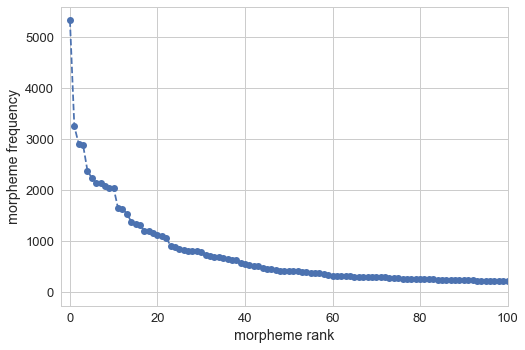

In [741]:
plt.plot(morpheme_count['index'],morpheme_count['freq'],linestyle='--', marker='o')
plt.xlim([-2,100])
plt.xlabel('morpheme rank')
plt.ylabel('morpheme frequency')

In [756]:
token_count['token_split'] = token_count['token'].apply(lambda w: morpho_segmentation(w))

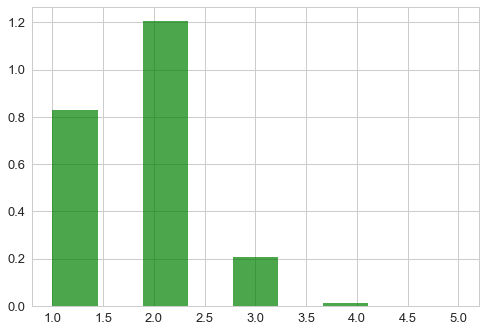

In [757]:
token_count['token_split_ct'] = token_count['token_split'].apply(len)
n, bins, patches = plt.hist(token_count['token_split_ct'], 9, normed=1, facecolor='green', alpha=0.7)

(0, 16)

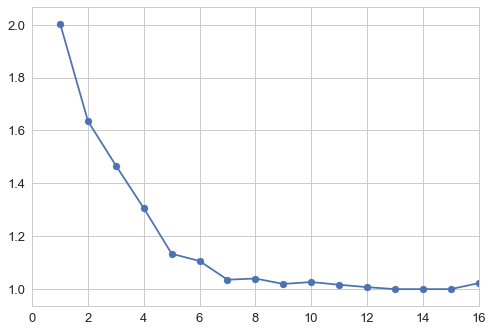

In [758]:
split_by_freq = token_count['token_split_ct'].groupby(token_count['freq']).mean().reset_index()
plt.scatter(split_by_freq['freq'],split_by_freq['token_split_ct'])
plt.plot(split_by_freq['freq'],split_by_freq['token_split_ct'])
plt.xlim([0,16])

In [760]:
token_count.sample(15)

,index,freq,token,constant,token_split,token_split_ct
6499,6499,3,soðfæstnyss,0,[soðfæstnyss],1
17649,17649,1,sinsorgna,0,"[sin, sorg, na]",3
6592,6592,3,wineþearfende,0,[wineþearfende],1
16211,16211,1,wrænnesse,0,"[wrænnes, se]",2
10643,10643,2,ealdgestreon,0,"[eald, gestreon]",2
5913,5913,3,iohannis,0,[iohannis],1
10875,10875,2,godspel,0,"[god, spel]",2
11201,11201,1,eorpes,0,"[eorp, es]",2
3159,3159,7,gefrunon,0,[gefrunon],1
22244,22244,1,þancedon,0,"[þanc, edon]",2


In [770]:
path2 = '/Users/ChadMorgan/Documents/old_english/OldEnglishPoetryCorpus/'
morpheme_count[morpheme_count['freq']>100][['index','morpheme','freq']].to_csv(
    path2+"/oe_morpheme_count.txt",sep='\t',index=False)

### Skipgram context pair sampling to generate training data

In [846]:
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Reshape, Activation, Input, Flatten, Lambda
from keras.layers.merge import Dot,Concatenate,Add
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams, pad_sequences
from keras.utils.np_utils import to_categorical
from keras import backend as K

In [825]:
index_token_dict = pd.Series(token_count.token.values,index=token_count.index+1).to_dict()
token_index_dict = pd.Series(token_count.index.values+1,index=token_count.token).to_dict()
index_morph_dict = pd.Series(morpheme_count.morpheme.values,index=morpheme_count.index+1).to_dict()
morph_index_dict = pd.Series(morpheme_count.index.values+1,index=morpheme_count.morpheme).to_dict()

In [829]:
# create tokenized sequences from each sentence in corpus
tokenized_corpus = []
for line in corpus_lines:
    line_token_idx = []
    for t in line.split():
        line_token_idx += [token_index_dict[t]]
    if len(line_token_idx)>1:
        tokenized_corpus += [line_token_idx]

print(corpus_lines[10])
print(tokenized_corpus[10])
print(len(tokenized_corpus))

V = len(token_set)+1
print(V)

wel hym þæs geweorkes ðonne he ða handlean hafað and sceawað gyf he ealteawne ende gedreogeð
[130, 4609, 25, 21071, 109, 7, 30, 7162, 159, 2, 4443, 1465, 7, 21072, 175, 21073]
10869
26978


In [812]:
def token_to_morph_idx_seq(w):
    morph_seq = []
    w_seg = morpho_segmentation(w)
    for m in w_seg:
        morph_seq.append(morph_index_dict[m]+1)
    return(morph_seq)

In [834]:
token_count[token_count['token']=='ealteawne']

,index,freq,token,constant,token_split,token_split_ct
167,167,108,no,0,[no],1


In [831]:
token_to_morph_idx_seq('ealteawne')

[151, 10445]

In [833]:
# use skipgram context sampling to generate training pairs
target_x = []
context_x = []
target_wordidx_x = []
context_wordidx_x = []

y = []
for i, doc in enumerate(shuffle(tokenized_corpus)):
    data, labels = skipgrams(sequence=doc, vocabulary_size=V
                             ,window_size=5, negative_samples=5.)

    for j,pair in enumerate(data):
        try:

            target_seq = token_to_morph_idx_seq(index_token_dict[pair[0]])
            context_seq = token_to_morph_idx_seq(index_token_dict[pair[1]])
            target_x.append(target_seq)
            context_x.append(context_seq)
            target_wordidx_x.append(pair[0])
            context_wordidx_x.append(pair[1])
            y.append(labels[j])
        except KeyError:
            continue

print(len(target_x))
print(len(context_x))
print(len(y))

print(target_x[0])
print(context_x[0])

8556408
8556408
8556408
[9]
[403, 310]


In [835]:
target_x = pad_sequences(target_x,maxlen=4)
context_x = pad_sequences(context_x,maxlen=4)

In [836]:
# train / validation split
target_x_train,target_x_valid, \
target_wordidx_train,target_wordidx_valid, \
context_x_train, context_x_valid, \
context_wordidx_train,context_wordidx_valid, \
y_train, y_valid = train_test_split(target_x,target_wordidx_x,context_x,context_wordidx_x,y,test_size = 0.2)

In [837]:
# convert everything to arrays
target_x_train = np.array(target_x_train)
target_x_valid = np.array(target_x_valid)
target_wordidx_train = np.array(target_wordidx_train)
target_wordidx_valid = np.array(target_wordidx_valid)
context_x_train = np.array(context_x_train)
context_x_valid = np.array(context_x_valid)
context_wordidx_train = np.array(context_wordidx_train)
context_wordidx_valid = np.array(context_wordidx_valid)

### Word-level embedding benchmark

In [838]:
dim_embedddings = 128

# target word
w_inputs = Input(shape=(1, ), dtype='int32')
w = Embedding(V, dim_embedddings)(w_inputs)

# context word
c_inputs = Input(shape=(1, ), dtype='int32')
c  = Embedding(V, dim_embedddings)(c_inputs)

# output: dot product of target and context vectors
o = Dot(axes=2)([w, c])
o = Reshape((1,), input_shape=(1, 1))(o)
o = Activation('sigmoid')(o)

SkipGram = Model(inputs=[w_inputs, c_inputs], outputs=o)
SkipGram.summary()
SkipGram.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 128)        3453184     input_1[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 128)        3453184     input_2[0][0]                    
___________________________________________________________________________________________

In [841]:
%%time
hist_word_sg = SkipGram.fit([target_wordidx_train, context_wordidx_train],
                     y_train,
                     batch_size=32, 
                     epochs=7, 
                     verbose=1,
                     validation_data=([target_wordidx_valid,context_wordidx_valid]
                                      ,y_valid))

Train on 6845126 samples, validate on 1711282 samples
Epoch 1/7
6845126/6845126 [==============================] - 17303s - loss: 0.4006 - acc: 0.9004 - val_loss: 0.4227 - val_acc: 0.9093
Epoch 2/7
6845126/6845126 [==============================] - 16903s - loss: 0.3851 - acc: 0.9181 - val_loss: 0.4428 - val_acc: 0.9041
Epoch 3/7
6845126/6845126 [==============================] - 16483s - loss: 0.3413 - acc: 0.9311 - val_loss: 0.4845 - val_acc: 0.8974
Epoch 4/7
6845126/6845126 [==============================] - 16672s - loss: 0.3108 - acc: 0.9400 - val_loss: 0.5316 - val_acc: 0.8937
Epoch 5/7
6845126/6845126 [==============================] - 16460s - loss: 0.2898 - acc: 0.9461 - val_loss: 0.5823 - val_acc: 0.8896
Epoch 6/7
6845126/6845126 [==============================] - 17428s - loss: 0.2748 - acc: 0.9505 - val_loss: 0.6372 - val_acc: 0.8837
Epoch 7/7
6845126/6845126 [==============================] - 18015s - loss: 0.2636 - acc: 0.9536 - val_loss: 0.6862 - val_acc: 0.8809
CPU time

In [843]:
path2 = "/Users/ChadMorgan/Documents/old_english/OldEnglishPoetryCorpus/"
SkipGram.save(path2+'word_skipgram_model.h5')

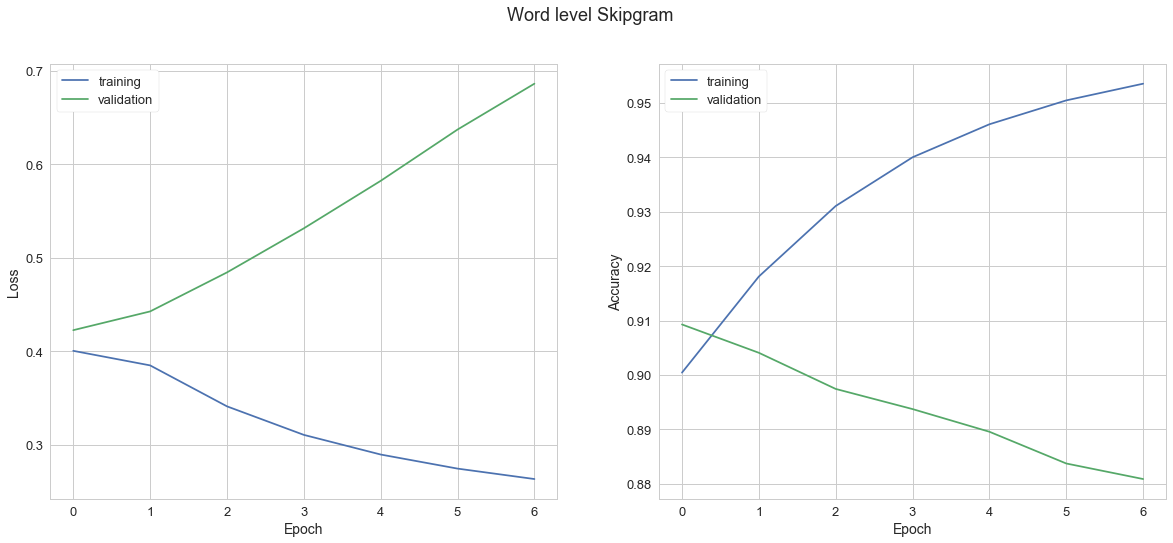

In [844]:
plt.figure(figsize=(20, 8))
plt.suptitle("Word level Skipgram", fontsize=18)
plt.subplot(121)
plt.plot(hist_word_sg.history["loss"], label="training")
plt.plot(hist_word_sg.history["val_loss"], label="validation")
#plt.plot(hist_rnnsg.history["val_loss"], label="Test")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.subplot(122)
plt.plot(hist_word_sg.history["acc"], label="training")
plt.plot(hist_word_sg.history["val_acc"], label="validation")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.show()

### Morpheme-sum compound embedding

In [867]:
dim_embedddings = 128
M = len(morpheme_set)+2

print(M)
print(len(morph_index_dict.keys()))

11983
11981


In [875]:
# target word
word_morph_input = Input(shape=(4, ), dtype='int32')
word_morph_embed = Embedding(M, dim_embedddings,mask_zero=True)(word_morph_input)
#word_morph_sum = Lambda(lambda x: K.sum(x, axis=1), output_shape=lambda s: (s[0], s[2]),name="target_embed_sum")(word_morph_embed)


# context word
context_morph_input = Input(shape=(4, ), dtype='int32')
context_morph_embed  = Embedding(M, dim_embedddings,mask_zero=True)(context_morph_input)
#context_morph_sum = Lambda(lambda x: K.sum(x, axis=1), output_shape=lambda s: (s[0], s[2]))(context_morph_embed)

# output: dot product of target and context vectors
dot_output = Dot(axes=1)([word_morph_sum, context_morph_sum])
dot_output = Reshape((1,), input_shape=(1, 1))(dot_output)
dot_output = Activation('sigmoid')(dot_output)

morph_SkipGram = Model(inputs=[word_morph_input, context_morph_input], outputs=dot_output)
morph_SkipGram.summary()
morph_SkipGram.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_30 (InputLayer)            (None, 4)             0                                            
____________________________________________________________________________________________________
input_31 (InputLayer)            (None, 4)             0                                            
____________________________________________________________________________________________________
embedding_30 (Embedding)         (None, 4, 128)        1533824     input_30[0][0]                   
____________________________________________________________________________________________________
embedding_31 (Embedding)         (None, 4, 128)        1533824     input_31[0][0]                   
___________________________________________________________________________________________

In [869]:
%%time
hist_morph_sg = morph_SkipGram.fit([target_x_train, context_x_train],
                     y_train,
                     batch_size=32, 
                     epochs=3, 
                     verbose=1,
                     validation_data=([target_x_valid,context_x_valid]
                                      ,y_valid))

Train on 6845126 samples, validate on 1711282 samples
Epoch 1/3
6845126/6845126 [==============================] - 7925s - loss: 0.3579 - acc: 0.8934 - val_loss: 0.3928 - val_acc: 0.8966
Epoch 2/3
6845126/6845126 [==============================] - 7733s - loss: 0.3758 - acc: 0.9030 - val_loss: 0.4453 - val_acc: 0.8830
Epoch 3/3
6845126/6845126 [==============================] - 8028s - loss: 0.3598 - acc: 0.9126 - val_loss: 0.4896 - val_acc: 0.8802
CPU times: user 16h 51min 40s, sys: 4h 33min 31s, total: 21h 25min 11s
Wall time: 6h 34min 49s


In [870]:
morph_SkipGram.save(path2+'morph_skipgram_model.h5')

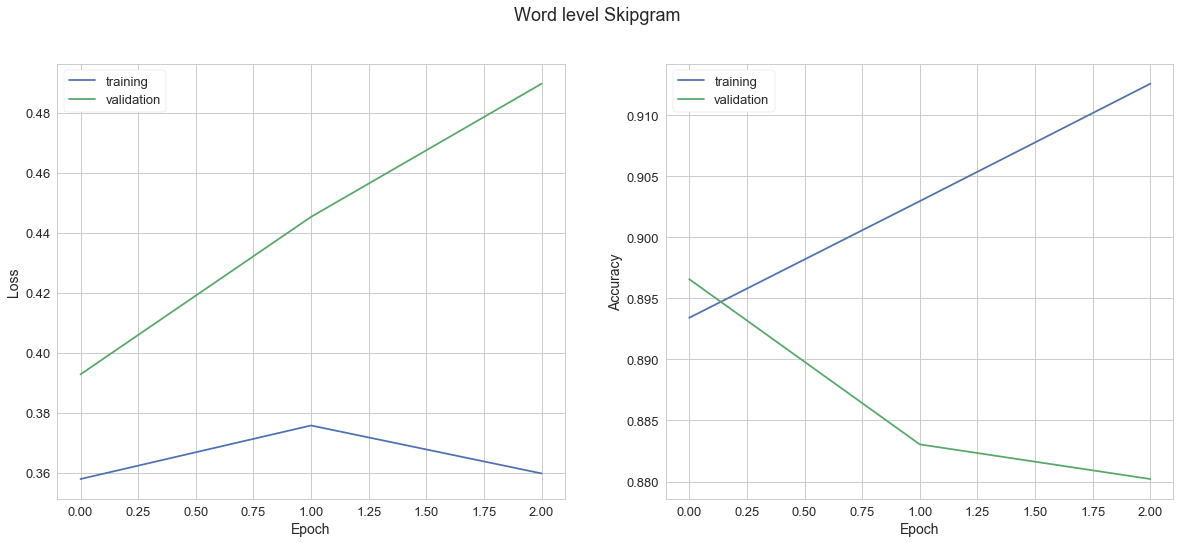

In [871]:
plt.figure(figsize=(20, 8))
plt.suptitle("Word level Skipgram", fontsize=18)
plt.subplot(121)
plt.plot(hist_morph_sg.history["loss"], label="training")
plt.plot(hist_morph_sg.history["val_loss"], label="validation")
#plt.plot(hist_rnnsg.history["val_loss"], label="Test")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.subplot(122)
plt.plot(hist_morph_sg.history["acc"], label="training")
plt.plot(hist_morph_sg.history["val_acc"], label="validation")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [876]:
embed_extract = Model(input=[word_morph_input]
                      , output=morph_SkipGram.get_layer("target_embed_sum").output)

/Users/ChadMorgan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ta...)`
  


In [889]:
w_ft_matrix = []
for w in token_index_dict.keys():
    try:
        w_ft_matrix.append(token_to_morph_idx_seq(w))
    except KeyError:
        print(w)
w_ft_matrix = pad_sequences(w_ft_matrix,maxlen=4)

In [897]:
w_ft_matrix[15000:15020]

array([[   0,    0, 4511,  400],
       [   0,    0,  902,  307],
       [   0,    0, 3591, 3600],
       [   0,    0, 2519, 3112],
       [   0,    0,    0, 6705],
       [   0,    0, 1197,  102],
       [   0,    0,    6, 9722],
       [   0,    0,  130,  514],
       [   0,    0, 3345, 1260],
       [   0,    0,    0, 7015],
       [   0,    0, 3559,   82],
       [   0,   27, 2073,   26],
       [   0,    0, 1711,  580],
       [   0,    0,  348,  899],
       [   0,    0,  954, 6015],
       [   0,    0,    0, 9721],
       [   0,    0, 6197,  577],
       [   0,    6,  903, 9723],
       [   0,    0, 1461, 3855],
       [   0, 4235,   42,    5]], dtype=int32)

In [893]:
char_sg_embed = embed_extract.predict(w_ft_matrix)

In [895]:
char_sg_embed.shape

(26977, 128)

### Morpheme embedding

Split embeddings into morphemes within sentences and learn usual skipgram w2v embedding at morpheme level

In [899]:
import gensim

In [920]:
corpus_morph_seq = []
for line in corpus_lines:
    line_morph_seq = []
    for word in line.split():
        for m in morpho_segmentation(word):
            line_morph_seq.append(m)
    corpus_morph_seq.append(line_morph_seq)

In [923]:
#print(corpus_lines[4])
print(corpus_morph_seq[1:4])

[['æla', 'dema', 'god'], ['geara', 'me', 'ece', 'waldend'], ['ic', 'wat', 'mine', 'saule', 'synnum', 'forwundod']]


In [964]:
model = gensim.models.Word2Vec(size=256, window=5, min_count=1,iter=50,sg=1,negative=7)
model.build_vocab(corpus_morph_seq)

In [965]:
model.train(shuffle(corpus_morph_seq),total_examples=model.corpus_count,epochs=model.iter)

8600701

In [961]:
model.wv.most_similar(positive=['sweord'])

[('etonisc', 0.5869967937469482),
 ('iren', 0.5518656373023987),
 ('entiscne', 0.5518093109130859),
 ('styled', 0.5470833778381348),
 ('dyhttig', 0.5365559458732605),
 ('siþadest', 0.5333367586135864),
 ('byrnan', 0.5231094360351562),
 ('ongenðiow', 0.5175120234489441),
 ('þruen', 0.5156667232513428),
 ('nhilt', 0.5070812702178955)]